## Distribution Setup

In [1]:
# from datasets import load_dataset
# from collections import defaultdict
# import random

# # Terapkan random seed untuk hasil yang dapat direproduksi
# random.seed(42)

# # Muat dataset
# dataset = load_dataset("bltlab/queryner")
# label_list = dataset['train'].features['ner_tags'].feature.names

# # --- 1. Konsolidasi Label BIO ---
# # Fungsi untuk menggabungkan label B- dan I- menjadi satu entitas
# consolidated_labels_map = {}
# consolidated_label_names = []
# for label in label_list:
#     if label.startswith('B-'):
#         entity_name = label[2:]
#         consolidated_labels_map[label] = entity_name
#         consolidated_label_names.append(entity_name)
#     elif label.startswith('I-'):
#         entity_name = label[2:]
#         consolidated_labels_map[label] = entity_name
#         consolidated_label_names.append(entity_name)
#     else: # 'O' label
#         consolidated_labels_map[label] = label
#         consolidated_label_names.append(label)
# consolidated_label_names = sorted(list(set(consolidated_label_names)))

# # Daftar label yang terpengaruh
# labels_to_plot = ['condition', 'quantity', 'price', 'origin', 'time', 'product_number']

# # Fungsi untuk menghitung entitas di split dan mengkonsolidasikan
# def count_and_consolidate(split_data):
#     counts = defaultdict(int)
#     for example in split_data:
#         for tag_id in example['ner_tags']:
#             original_label = label_list[tag_id]
#             consolidated_label = consolidated_labels_map[original_label]
#             counts[consolidated_label] += 1
#     return counts

# # Fungsi untuk menghitung data dan persentase
# def calculate_distribution(counts, labels_to_check):
#     plot_data = defaultdict(dict)
#     total_counts = {}

#     for label in labels_to_check:
#         total_counts[label] = sum(counts[split][label] for split in ['train', 'validation', 'test'])

#     for label in labels_to_check:
#         total = total_counts[label]
#         if total > 0:
#             for split in ['train', 'validation', 'test']:
#                 count = counts[split][label]
#                 percentage = (count / total) * 100 if total > 0 else 0
#                 plot_data[label][split] = {'percentage': round(percentage, 2), 'count': count}
#         else:
#             for split in ['train', 'validation', 'test']:
#                 plot_data[label][split] = {'percentage': 0, 'count': 0}

#     return plot_data

# # --- Tahap Awal: Hitung Distribusi Sebelum Penyesuaian ---
# print("Menghitung distribusi entitas sebelum penyesuaian...")
# initial_counts = {
#     'train': count_and_consolidate(dataset['train']),
#     'validation': count_and_consolidate(dataset['validation']),
#     'test': count_and_consolidate(dataset['test'])
# }
# initial_distribution = calculate_distribution(initial_counts, labels_to_plot)

# # --- Tahap Penyesuaian Distribusi Entitas ---
# print("\nMelakukan penyesuaian distribusi entitas...")
# rebalanced_dataset = {split: list(dataset[split]) for split in dataset.keys()}

# def move_samples(source_split_name, dest_split_name, label_to_move, num_to_move):
#     global rebalanced_dataset
    
#     source_split = rebalanced_dataset[source_split_name]
#     dest_split = rebalanced_dataset[dest_split_name]
    
#     potential_indices = [i for i, example in enumerate(source_split) if any(label_to_move in label_list[tag_id] for tag_id in example['ner_tags'])]
    
#     if len(potential_indices) >= num_to_move:
#         indices_to_remove = random.sample(potential_indices, num_to_move)
#     else:
#         indices_to_remove = potential_indices
    
#     if len(indices_to_remove) > 0:
#         samples_to_move = [source_split[i] for i in indices_to_remove]
#         for i in sorted(indices_to_remove, reverse=True):
#             del source_split[i]
#         dest_split.extend(samples_to_move)

# # Terapkan penyesuaian yang dijelaskan:
# move_samples('train', 'test', 'condition', 15)
# move_samples('test', 'train', 'quantity', 5)
# move_samples('train', 'validation', 'price', 3)
# move_samples('train', 'test', 'price', 2)
# move_samples('test', 'validation', 'origin', 3)
# move_samples('train', 'test', 'time', 3)
# move_samples('test', 'validation', 'product_number', 3)

# # --- Tahap Akhir: Hitung ulang distribusi setelah penyesuaian ---
# print("\nPenyesuaian selesai. Menghitung ulang distribusi entitas...")
# final_counts = {
#     'train': count_and_consolidate(rebalanced_dataset['train']),
#     'validation': count_and_consolidate(rebalanced_dataset['validation']),
#     'test': count_and_consolidate(rebalanced_dataset['test'])
# }
# final_distribution = calculate_distribution(final_counts, labels_to_plot)

In [2]:
# import os
# import json

# # Create directories if they don't exist
# os.makedirs('data/raw', exist_ok=True)
# os.makedirs('data/processed', exist_ok=True)
# os.makedirs('data/distribution', exist_ok=True)

# # Save original dataset to raw folder
# print("\nSaving original dataset...")
# for split in dataset.keys():
#     dataset[split].to_json(f'data/raw/{split}.json')
# print("Original dataset saved to data/raw/")

# # Save rebalanced dataset to processed folder
# print("\nSaving processed dataset...")
# for split, data in rebalanced_dataset.items():
#     # Convert list of examples to a format that can be saved
#     processed_data = {
#         'examples': data
#     }
#     with open(f'data/processed/{split}.json', 'w', encoding='utf-8') as f:
#         json.dump(processed_data, f, ensure_ascii=False, indent=2)
# print("Processed dataset saved to data/processed/")

# # Save distributions to distribution folder
# print("\nSaving distribution data...")
# distribution_data = {
#     'initial_distribution': initial_distribution,
#     'final_distribution': final_distribution
# }
# with open('data/distribution/label_distributions.json', 'w', encoding='utf-8') as f:
#     json.dump(distribution_data, f, ensure_ascii=False, indent=2)
# print("Distribution data saved to data/distribution/label_distributions.json")

## Data Preparation

In [3]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig

In [4]:
class NERDataset(Dataset):
    def __init__(self, data_path, tokenizer, label_pad_id=-100, max_length=128):
        with open(data_path, "r", encoding="utf-8") as f:
            raw = json.load(f)["examples"]
        self.data = raw
        self.tokenizer = tokenizer
        self.label_pad_id = label_pad_id
        self.max_length = max_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tokens = self.data[idx]["tokens"]
        ner_tags = self.data[idx]["ner_tags"]

        # buat encoding untuk tokens 
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )

        # align labels dengan tokens yang sudah diencoding (jadi kepotong2 sesuai tokenization)
        word_ids = encoding.word_ids(batch_index=0)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(self.label_pad_id)
            elif word_idx != previous_word_idx:
                aligned_labels.append(ner_tags[word_idx])
            else:
                aligned_labels.append(self.label_pad_id)
            previous_word_idx = word_idx
        
        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(aligned_labels, dtype=torch.long)
        }

        return item

In [5]:
def load_label_info(model_name):
    config = AutoConfig.from_pretrained(model_name)
    id2label = config.id2label
    label2id = config.label2id
    num_labels = config.num_labels

    label_info = {
        "id2label": id2label,
        "label2id": label2id,
        "num_labels": num_labels
    }

    return label_info

def create_dataloaders(
        train_path, val_path, test_path,
        model_name,
        batch_size=32,
        max_length=128
):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_dataset = NERDataset(train_path, tokenizer, max_length=max_length)
    val_dataset = NERDataset(val_path, tokenizer, max_length=max_length)
    test_dataset = NERDataset(test_path, tokenizer, max_length=max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [6]:
train_loader, val_loader, test_loader = create_dataloaders(
    train_path=r"D:\Dafa\Project\queryner-kd\data\processed\train.json",
    val_path=r"D:\Dafa\Project\queryner-kd\data\processed\validation.json",
    test_path=r"D:\Dafa\Project\queryner-kd\data\processed\test.json",
    model_name="bert-base-uncased",
    batch_size=16,
    max_length=128
)

label_info = load_label_info("bltlab/queryner-augmented-data-bert-base-uncased")

## Model Architecture

In [7]:
from torch import nn
from torchcrf import CRF
from transformers import AutoModel, AutoConfig

In [ ]:
class CRFOutputLayer(nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super().__init__()
        self.fc = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_tags=num_labels, batch_first=True)

    def forward(self, outputs, labels=None, mask=None):
        emissions = self.fc(outputs)

        if labels is not None:
            # CRF requires first token to be valid, so we create a modified mask
            # that ensures first token is always included
            if mask is None:
                mask = torch.ones_like(labels, dtype=torch.bool)
            else:
                mask = mask.bool()
            
            # Ensure first position is always valid for CRF
            mask[:, 0] = True
            
            # Replace -100 with 0 (dummy label) to avoid index issues
            labels_crf = labels.clone()
            labels_crf[labels == -100] = 0
            
            # Calculate loss
            log_likelihood = self.crf(emissions, tags=labels_crf, mask=mask, reduction="mean")
            loss = -log_likelihood
            return {"logits": emissions, "loss": loss}
        else:
            if mask is None:
                mask = torch.ones(outputs.shape[:2], dtype=torch.bool, device=outputs.device)
            pred = self.crf.decode(emissions, mask=mask.bool())
            return {"logits": emissions, "pred": pred}


In [9]:
class BaseNERModel(nn.Module):
    def __init__(self, num_labels, use_crf=False):
        super().__init__()
        self.num_labels = num_labels
        self.use_crf = use_crf

    def forward(self, input_ids, attention_mask, labels=None):
        raise NotImplementedError("Forward method must be implemented in subclass.")

In [10]:
class QueryNERTeacher(BaseNERModel):
    def __init__(self, model_name, label_info, use_crf=False):
        super().__init__(num_labels=label_info["num_labels"], use_crf=use_crf)

        self.config = AutoConfig.from_pretrained(
            model_name,
            num_labels=label_info["num_labels"],
            id2label=label_info["id2label"],
            label2id=label_info["label2id"]
        )

        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.1)

        if self.use_crf:
            self.crf_output = CRFOutputLayer(self.config.hidden_size, self.config.num_labels)
        else:
            self.classifier = nn.Linear(self.config.hidden_size, self.config.num_labels)
            self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, input_ids, attention_mask, labels=None):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)

        if self.use_crf:
            mask = attention_mask.bool()
            result = self.crf_output(sequence_output, labels=labels, mask=mask)
            return result

        else:
            logits = self.classifier(sequence_output)
            if labels is not None:
                loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
                return {"logits": logits, "loss": loss}
            else:
                pred = logits.argmax(dim=-1)
                return {"logits": logits, "pred": pred}

In [11]:
class DistilBERTStudent(BaseNERModel):
    def __init__(self, model_name="distilbert-base-uncased", label_info=None, use_crf=False):
        self.use_crf = use_crf
        self.num_labels = label_info["num_labels"]
        super().__init__(num_labels=self.num_labels, use_crf=self.use_crf)

        self.config = AutoConfig.from_pretrained(
            model_name,
            num_labels=label_info["num_labels"],
            id2label=label_info["id2label"],
            label2id=label_info["label2id"]
        )

        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.1)

        if self.use_crf:
            self.crf_output = CRFOutputLayer(self.config.hidden_size, self.num_labels)
        else:
            self.classifier = nn.Linear(self.config.hidden_size, self.num_labels)
            self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)

        if self.use_crf:
            mask = attention_mask.bool()
            result = self.crf_output(sequence_output, labels=labels, mask=mask)
            return result
        else:
            logits = self.classifier(sequence_output)
            if labels is not None:
                loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
                return {"logits": logits, "loss": loss}
            else:
                pred = logits.argmax(dim=-1)
                return {"logits": logits, "pred": pred}


In [12]:
teacher = QueryNERTeacher("bltlab/queryner-augmented-data-bert-base-uncased", label_info=label_info, use_crf=True)

Some weights of BertModel were not initialized from the model checkpoint at bltlab/queryner-augmented-data-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
student = DistilBERTStudent(label_info=label_info, use_crf=False)

## Knowledge Distillation Scheme

In [14]:
import torch.nn.functional as F

In [15]:
# src/training/kd_trainer.py
def softmax_with_temperature(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

def kl_divergence_loss(student_logits, teacher_logits, temperature):
    p_teacher = F.log_softmax(teacher_logits / temperature, dim=-1)
    p_student = F.softmax(student_logits / temperature, dim=-1)
    loss = F.kl_div(p_teacher, p_student, reduction='batchmean')
    loss = loss * (temperature ** 2)
    return loss

In [16]:
# src/training/kd_trainer.py
import torch
from tqdm.auto import tqdm

class KDTrainer:
    def __init__(
        self,
        teacher_model,
        student_model,
        train_loader,
        val_loader,
        optimizer,
        scheduler=None,
        device="cuda",
        alpha=0.5,
        beta=0.5,
        temperature=2.0
    ):
        self.teacher = teacher_model.to(device)
        self.student = student_model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.alpha = alpha
        self.beta = beta
        self.T = temperature

        # teacher tidak dilatih
        for p in self.teacher.parameters():
            p.requires_grad = False

    def compute_losses(self, batch):
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)
        labels = batch["labels"].to(self.device)

        with torch.no_grad():
            teacher_out = self.teacher(input_ids, attention_mask)
            teacher_logits = teacher_out["logits"]
        student_out = self.student(input_ids, attention_mask, labels)
        student_logits = student_out["logits"]

        # Hitung L_KD
        loss_kd = kl_divergence_loss(student_logits, teacher_logits, self.T)

        # Hitung L_S (loss student normal)
        loss_student = (
            student_out["loss"] if "loss" in student_out else torch.tensor(0)
        )

        # L_T (total)
        loss_total = self.alpha * loss_kd + self.beta * loss_student

        return loss_total, loss_kd, loss_student

    def train_epoch(self):
        self.student.train()
        total_loss, total_kd, total_stu = 0, 0, 0

        for batch in tqdm(self.train_loader, desc="Training"):
            self.optimizer.zero_grad()
            loss_total, loss_kd, loss_student = self.compute_losses(batch)
            loss_total.backward()
            self.optimizer.step()

            total_loss += loss_total.item()
            total_kd += loss_kd.item()
            total_stu += loss_student.item()

        avg_loss = total_loss / len(self.train_loader)
        avg_kd = total_kd / len(self.train_loader)
        avg_stu = total_stu / len(self.train_loader)

        if self.scheduler:
            self.scheduler.step(avg_loss)

        return avg_loss, avg_kd, avg_stu

    def validate(self):
        self.student.eval()
        total_loss, total_kd, total_stu = 0, 0, 0

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                loss_total, loss_kd, loss_student = self.compute_losses(batch)
                total_loss += loss_total.item()
                total_kd += loss_kd.item()
                total_stu += loss_student.item()

        avg_loss = total_loss / len(self.val_loader)
        avg_kd = total_kd / len(self.val_loader)
        avg_stu = total_stu / len(self.val_loader)
        return avg_loss, avg_kd, avg_stu

    def train(self, num_epochs):
        history = {"train_loss": [], "val_loss": [], "train_kd": [], "val_kd": [], "train_stu": [], "val_stu": []}

        for epoch in range(1, num_epochs + 1):
            print(f"\n===== EPOCH {epoch} =====")
            train_loss, train_kd, train_stu = self.train_epoch()
            val_loss, val_kd, val_stu = self.validate()

            print(
                f"Train: total={train_loss:.4f}, KD={train_kd:.4f}, S={train_stu:.4f} | "
                f"Val: total={val_loss:.4f}, KD={val_kd:.4f}, S={val_stu:.4f}"
            )

            history["train_loss"].append(train_loss)
            history["train_kd"].append(train_kd)
            history["train_stu"].append(train_stu)
            history["val_loss"].append(val_loss)
            history["val_kd"].append(val_kd)
            history["val_stu"].append(val_stu)

        return history

In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(student.parameters(), lr=1e-4)

trainer = KDTrainer(
    teacher_model=teacher,
    student_model=student,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    alpha=0.7,
    beta=0.3,
    temperature=4.0
)

In [18]:
history = trainer.train(num_epochs=10)


===== EPOCH 1 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

c:\Users\user\anaconda3\envs\gnn\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=10.9692, KD=7.2574, S=19.6299 | Val: total=9.8842, KD=6.6156, S=17.5111

===== EPOCH 2 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=9.4077, KD=6.7380, S=15.6370 | Val: total=8.6310, KD=6.4687, S=13.6764

===== EPOCH 3 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=8.4117, KD=6.6411, S=12.5431 | Val: total=7.8769, KD=6.3843, S=11.3595

===== EPOCH 4 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=7.8725, KD=6.5951, S=10.8532 | Val: total=7.5145, KD=6.3615, S=10.2049

===== EPOCH 5 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=7.5985, KD=6.5717, S=9.9943 | Val: total=7.3282, KD=6.3555, S=9.5979

===== EPOCH 6 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=7.4565, KD=6.5617, S=9.5444 | Val: total=7.2364, KD=6.3621, S=9.2764

===== EPOCH 7 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=7.3756, KD=6.5587, S=9.2818 | Val: total=7.1711, KD=6.3552, S=9.0746

===== EPOCH 8 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=7.3237, KD=6.5578, S=9.1107 | Val: total=7.1326, KD=6.3555, S=8.9458

===== EPOCH 9 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=7.2863, KD=6.5550, S=8.9926 | Val: total=7.1060, KD=6.3592, S=8.8486

===== EPOCH 10 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=7.2627, KD=6.5584, S=8.9061 | Val: total=7.0732, KD=6.3405, S=8.7827


## Empty Cache, Save History, and Plotting

In [19]:
# clear GPU memory
# torch.cuda.empty_cache()

In [20]:
json_file_name = "results/Tqueryner-Sdistilbert-lr10-5"
img_folder_path = "results/img/crf-lr10-4/"

In [21]:
import json
#  save history to json
with open(f"{json_file_name}.json", "w") as f:
    json.dump(history, f, indent=4)

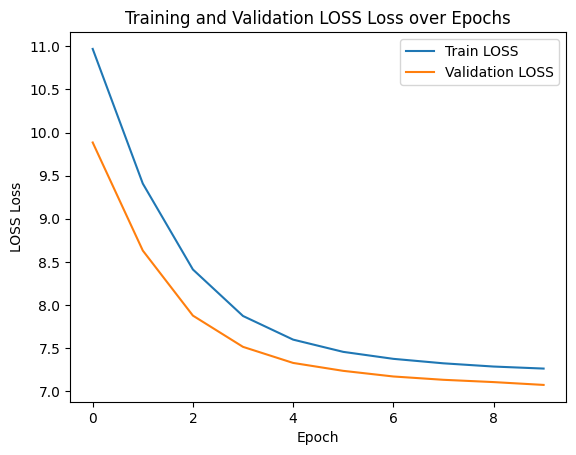

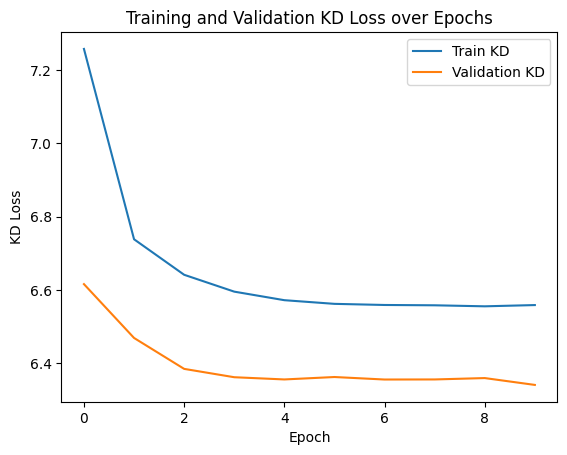

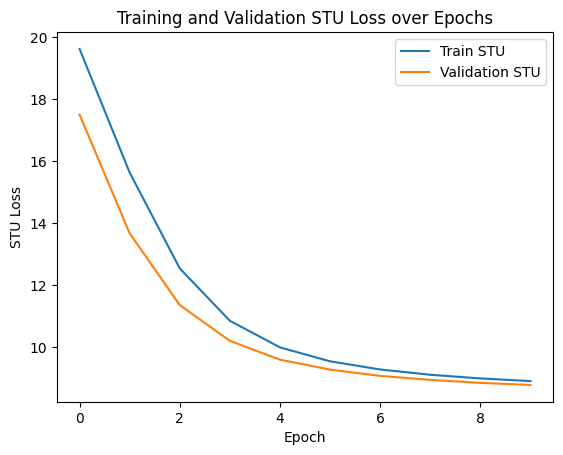

In [22]:
import matplotlib.pyplot as plt
import os

os.makedirs(img_folder_path, exist_ok=True)

list_to_plot = ["loss", "kd", "stu"]
for item in list_to_plot:
    plt.plot(history[f"train_{item}"], label=f"Train {item.upper()}")
    plt.plot(history[f"val_{item}"], label=f"Validation {item.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{item.upper()} Loss")
    plt.legend()
    plt.title(f"Training and Validation {item.upper()} Loss over Epochs")
    plt.savefig(f"{img_folder_path}{item}.png") 
    plt.show()
    plt.close()

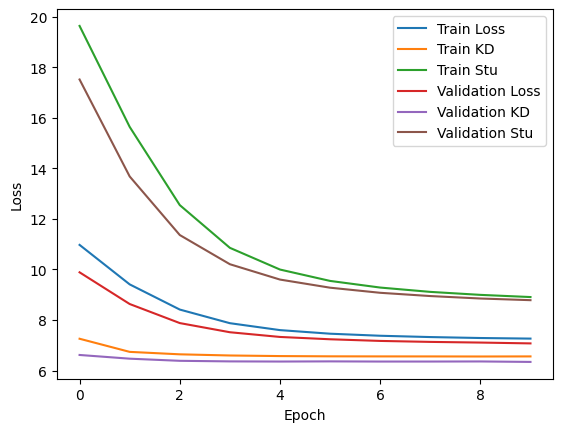

In [23]:
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["train_kd"], label="Train KD")
plt.plot(history["train_stu"], label="Train Stu")
plt.plot(history["val_loss"], label="Validation Loss")
plt.plot(history["val_kd"], label="Validation KD")
plt.plot(history["val_stu"], label="Validation Stu")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{img_folder_path}all_losses.png")
plt.show()